In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim

In [2]:
gamma = 0.9

In [36]:
def Normalization(df):
    df.iloc[:,2:]= df.iloc[:,2:].apply(lambda x: ((x-x.mean()) / (x.std())))
    return df

In [37]:
def preprocessing(path):
    df = pd.read_csv(path, header=None, delimiter=' ')
    
    #Normalize the data
    df = Normalization(df)
    
    #Drop the columns which has all values as Nan
    df.dropna(axis=1, how='all', inplace=True)
    
    #Get Rewards for each time step : 0 except last time step where reward is -100
    df['Counter'] = df.index
    lastRowIndex = df.groupby(0).last().Counter.tolist()
    df['reward'] = df['Counter'].apply(lambda x : -100 if x in lastRowIndex else 0 )
    df.drop(columns=['Counter'],inplace=True)
    
    #Rename columns
    df.rename(columns={0: "machine", 1: "time"}, inplace=True)
    
    #Calculate Monte Carlo Value for each row
    df1 = df.groupby('machine').last()[['time']].reset_index()
    df = pd.merge(df, df1, on = 'machine', how = 'left').rename(columns ={'time_x':'time','time_y':'lastTimeStamp'})
    df['MC_Val'] = (gamma ** (df['lastTimeStamp'] - df['time'] )) * (-100)
    df = df.drop(columns='lastTimeStamp')
    
    return df

In [45]:
df = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/train_FD001.txt")

## We have added the reward and Val column. We will be using the Val column for the Monte Carlo return gamma**(T-t)  X  -100

## Now lets build the Neural network for the predictron

In [7]:
#Neural network for Observation - Hidden State

In [8]:
class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
input_size  = 24
out_size = 4
net = NN_OH(input_size, out_size)
print(net)

NN_OH(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [10]:
#Neural network for Hidden State - Reward & Value

In [11]:
class NN_reward_val(nn.Module):
    def __init__(self, input_size):
        super(NN_reward_val,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
##Neural Network which will take my current hidden state to the next hidden state

In [13]:
class NN_HH(nn.Module):
    def __init__(self, input_size):
        super(NN_HH,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,input_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictron(nn.Module):
    def __init__(self, obs_size, hid_size):
        super(Predictron,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.fc1 = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.fc2 = NN_reward_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.fc3 = NN_HH(hid_size)
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.fc1(x)
        
        #Now we keep track of rewards for the k-step return
        k=10
        gamma = 0.9 #Discount Factor
        reward = self.fc2(x)[:,0].reshape(-1,1)
        #print(reward.shape)
        for i in range(k-1):
            #Take the next step
            x = self.fc3(x)
            reward += gamma*(self.fc2(x)[:,0].reshape(-1,1))
        
        val_kth = self.fc2(x)[:,1].reshape(-1,1)
        
        return reward+val_kth
            
        

In [47]:
x = torch.tensor(df.iloc[:, 2:-2].values).float()

In [49]:
x.shape

torch.Size([20631, 21])

In [50]:
y_target = torch.tensor(df.iloc[:,-1].values).float()
y_target = y_target.reshape(-1,1)

In [51]:
y_target.shape

torch.Size([20631, 1])

In [52]:
core = Predictron(x.shape[1], 4)
optimizer = optim.Adam(core.parameters(), lr = 1e-3) 

In [53]:
for p in core.parameters():
    print(p)

Parameter containing:
tensor([[-0.0622,  0.0653, -0.0565,  ..., -0.0020,  0.1188, -0.0421],
        [ 0.0970,  0.0525, -0.0403,  ...,  0.0590,  0.1086,  0.2023],
        [ 0.0337,  0.0763, -0.0384,  ...,  0.0860, -0.0680,  0.0994],
        ...,
        [ 0.0535, -0.0983, -0.1750,  ..., -0.0259, -0.0709,  0.1269],
        [ 0.0216,  0.0153, -0.1540,  ...,  0.0612, -0.0131, -0.1431],
        [-0.0856, -0.0237,  0.1316,  ..., -0.1657, -0.1346,  0.1800]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0854,  0.0286, -0.1152,  0.1265,  0.0671,  0.1372,  0.1355,  0.2180,
         0.0128, -0.0915, -0.1091, -0.1731,  0.0942,  0.1300, -0.0557,  0.2142,
         0.2149,  0.0527,  0.1224,  0.0886, -0.1496,  0.2085,  0.1418, -0.1031,
         0.0075,  0.0262,  0.0989,  0.1009, -0.1228, -0.0096, -0.0915,  0.0479,
         0.0764,  0.1064,  0.2101, -0.1426,  0.1012,  0.0392, -0.0085, -0.1507,
         0.0668, -0.1366, -0.0620,  0.1245,  0.1772, -0.1851, -0.0659,  0.1420,
        -0.0155

In [55]:
loss_fn = nn.MSELoss()

In [56]:
n_epochs = 30 # or whatever
batch_size = 128 # or whatever
losses=[]
for epoch in range(n_epochs):

    # x is our input
    permutation = torch.randperm(x.size()[0])

    for i in range(0,x.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y_target[indices]

        # in case you wanted a semi-full example
        outputs = core.forward(batch_x)
        loss = loss_fn(outputs,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Loss after:"+str(epoch)+" iterations is :"+ str(loss))

Loss after:0 iterations is :tensor(29.6008, grad_fn=<MseLossBackward>)
Loss after:1 iterations is :tensor(61.5052, grad_fn=<MseLossBackward>)
Loss after:2 iterations is :tensor(20.6799, grad_fn=<MseLossBackward>)
Loss after:3 iterations is :tensor(92.8271, grad_fn=<MseLossBackward>)
Loss after:4 iterations is :tensor(4.4778, grad_fn=<MseLossBackward>)
Loss after:5 iterations is :tensor(63.4296, grad_fn=<MseLossBackward>)
Loss after:6 iterations is :tensor(40.2566, grad_fn=<MseLossBackward>)
Loss after:7 iterations is :tensor(1.7224, grad_fn=<MseLossBackward>)
Loss after:8 iterations is :tensor(5.7516, grad_fn=<MseLossBackward>)
Loss after:9 iterations is :tensor(5.1931, grad_fn=<MseLossBackward>)
Loss after:10 iterations is :tensor(5.6642, grad_fn=<MseLossBackward>)
Loss after:11 iterations is :tensor(9.0096, grad_fn=<MseLossBackward>)
Loss after:12 iterations is :tensor(95.5353, grad_fn=<MseLossBackward>)
Loss after:13 iterations is :tensor(0.7449, grad_fn=<MseLossBackward>)
Loss afte

Text(0, 0.5, 'Loss')

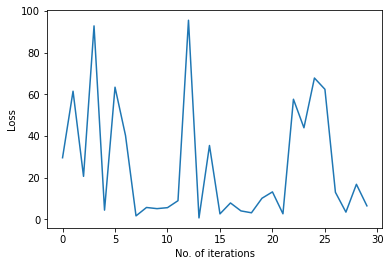

In [57]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")

In [58]:
for p in core.parameters():
    print(p)

Parameter containing:
tensor([[-0.0413,  0.0039, -0.1608,  ...,  0.0169,  0.0957, -0.0936],
        [ 0.0313,  0.1269,  0.1784,  ...,  0.1326,  0.0120,  0.1751],
        [ 0.0120,  0.0076, -0.1330,  ...,  0.1366, -0.1324,  0.0191],
        ...,
        [ 0.1292, -0.3407, -0.0050,  ..., -0.1420, -0.0594,  0.1954],
        [ 0.0236, -0.0176, -0.2390,  ...,  0.0812, -0.0611, -0.2153],
        [-0.0803, -0.0446,  0.0326,  ..., -0.1332, -0.1822,  0.1025]],
       requires_grad=True)
Parameter containing:
tensor([-0.0189,  0.2474, -0.2099,  0.0453,  0.2067,  0.0221, -0.0157,  0.0921,
         0.2276, -0.0227, -0.2096, -0.2449,  0.0010,  0.0864,  0.1494,  0.0873,
         0.1056, -0.0527, -0.0291, -0.0453, -0.2549,  0.1049,  0.2446, -0.1311,
        -0.0981, -0.0759, -0.0673,  0.1196, -0.2289, -0.1428,  0.1698, -0.1120,
        -0.0213,  0.2983,  0.2985,  0.0269, -0.0502,  0.1394, -0.1103, -0.2975,
        -0.0466, -0.2213, -0.1534, -0.0296,  0.0388, -0.2979,  0.1631,  0.3024,
        -0.1375

In [64]:
sample = df.iloc[190:200,2:-2]
sample = torch.tensor(sample.values).float()
sample.shape

predict = core.forward(sample)

In [65]:
predict

tensor([[-59.4047],
        [-68.6851],
        [  0.1173],
        [  0.1600],
        [  0.1383],
        [  0.1624],
        [  0.1428],
        [  0.1669],
        [  0.1430],
        [  0.1547]], grad_fn=<AddBackward0>)

In [66]:
y_target[190:200,:]

tensor([[-9.0000e+01],
        [-1.0000e+02],
        [-8.1914e-12],
        [-9.1015e-12],
        [-1.0113e-11],
        [-1.1236e-11],
        [-1.2485e-11],
        [-1.3872e-11],
        [-1.5414e-11],
        [-1.7126e-11]])